Wine quality dataset from: https://archive.ics.uci.edu/ml/datasets/Wine+Quality

In [1]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true', delimiter=';')\
    .load('../data/winequality-white.csv')

In [2]:
df.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



In [3]:
df.count()

4898

In [4]:
df.registerTempTable('wine')
sqlContext.sql("SELECT quality, avg(alcohol) AS avg_alcohol FROM wine GROUP BY quality").collect()

[Row(quality=3, avg_alcohol=10.345),
 Row(quality=4, avg_alcohol=10.152453987730064),
 Row(quality=5, avg_alcohol=9.808840082361012),
 Row(quality=6, avg_alcohol=10.575371549893838),
 Row(quality=7, avg_alcohol=11.367935606060609),
 Row(quality=8, avg_alcohol=11.635999999999997),
 Row(quality=9, avg_alcohol=12.18)]

In [5]:
data = sqlContext.sql("SELECT *, CAST(quality AS DOUBLE) AS label FROM wine")
data.cache()

DataFrame[fixed acidity: double, volatile acidity: double, citric acid: double, residual sugar: double, chlorides: double, free sulfur dioxide: double, total sulfur dioxide: double, density: double, pH: double, sulphates: double, alcohol: double, quality: int, label: double]

Let's try some machine learning

In [6]:
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["sulphates", "density", "alcohol"],
    outputCol="features")
output = assembler.transform(data)
print(output.select("features", "label").first())

Row(features=DenseVector([0.45, 1.001, 8.8]), label=6.0)


Lets build and evaluate a regularised linear regression model

In [9]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

(trainingData, testData) = data.randomSplit([0.7, 0.3])

lr = LinearRegression(maxIter=30, regParam=0.3, elasticNetParam=0.8, featuresCol="features", labelCol="label")

pipeline = Pipeline(stages=[assembler, lr])

# Train model.  This also runs the indexer.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

In [10]:
lrModel = model.stages[1]
# summary only
print(lrModel.coefficients)
print(lrModel.intercept)

[0.0,0.0,0.106798840072]
4.75862526587


In [11]:
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.850946


Let's visualise data using PCA for dimensinality reduction

In [12]:
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import PCA
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline


all_assembler = VectorAssembler(
    inputCols=["sulphates", "density", "alcohol"],
#    inputCols=map(lambda s:s.name,df.schema.fields)[:-1],
    outputCol="features")
normalizer = Normalizer(inputCol="features", outputCol="norm_features")
pca = PCA(k=2, inputCol="norm_features", outputCol="pca_features")

pca_pipeline = Pipeline(stages=[all_assembler, normalizer, pca])

pca_model = pca_pipeline.fit(data)

pca_model.transform(data).first()

Row(fixed acidity=7.0, volatile acidity=0.27, citric acid=0.36, residual sugar=20.7, chlorides=0.045, free sulfur dioxide=45.0, total sulfur dioxide=170.0, density=1.001, pH=3.0, sulphates=0.45, alcohol=8.8, quality=6, label=6.0, features=DenseVector([0.45, 1.001, 8.8]), norm_features=DenseVector([0.0507, 0.1129, 0.9923]), pca_features=DenseVector([-0.013, -0.0169]))

In [13]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

Populating the interactive namespace from numpy and matplotlib


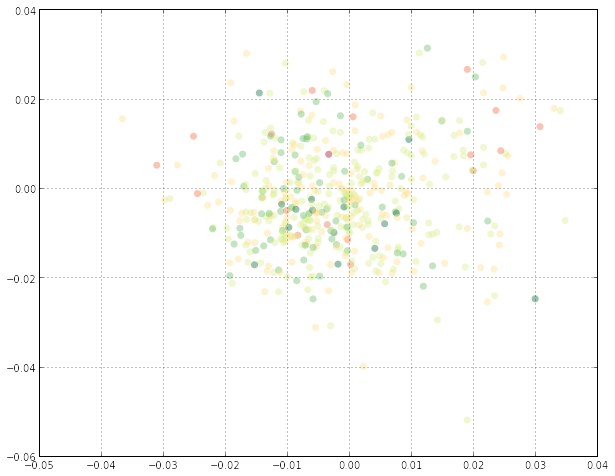

In [15]:
import matplotlib.pyplot as plt
pca_data = pca_model.transform(data)

sampling_fraction = 0.1

pca_xy = np.matrix(map(lambda r:r.pca_features.array, pca_data.sample(False, sampling_fraction, 13).collect()))
pca_colors = map(lambda r: float(r.quality),data.select('quality').sample(False, sampling_fraction, 13).collect())

plt.scatter(pca_xy[:,0], pca_xy[:,1], c=pca_colors, alpha=0.4, cmap=plt.get_cmap('RdYlGn'), edgecolors='none', s=50)
plt.grid(True)
plt.show()